In [1]:
import torch
import sys, os
module_rootdir = '../../..'
dataset_rootdir = '../../../..'
label_rootdir = module_rootdir
sys.path.append(module_rootdir)

import config_dataset
from modules.proposal.constants import _IGNORED_CLASS_DEFAULT_ID_
from modules.dataset_utils.kitti_dataset_utils.constants import _IGNORED_CLASS_ID_
from modules.dataset_utils.kitti_dataset_utils import constants
from modules.dataset_utils.kitti_objdetect_dataloader import KittiTrackingDataset_2DObjectDetection, extract_valid_bbox
from modules.proposal.box_association import fcos_match_locations_to_gt_main
from modules.proposal.box_functions import gen_grid_coord
from modules.plot.viz_annotation import vizualize_bbox_resized, visualize_centerness
from modules.dataset_utils.kitti_dataset_utils.kitti_remap_utils import load_all_sequence_groundtruths_json
from modules.proposal.prop_functions import (
    compute_centerness, shrink_bbox_and_compute_centerness, compute_centerness_gaussian,
    fcos_get_deltas_from_locations )
from modules.proposal.constants import _SHRINK_FACTOR_, _MATCH_CRITERIA_

device = 'cuda'

import matplotlib.pyplot as plt
import numpy as np

color_generator_fn = plt.cm.magma

# color_generator_fn = plt.cm.YlOrRd
# color_generator_fn = plt.cm.plasma
# color_generator_fn = plt.cm.inferno
# color_generator_fn = plt.cm.magma
# color_generator_fn = plt.cm.Blues
# color_generator_fn = plt.cm.Greens
# color_generator_fn = plt.cm.Reds
# color_generator_fn = plt.cm.PuRd
# color_generator_fn = plt.cm.Oranges

def generate_color(centerness):
    min_val = np.min(centerness)
    max_val = np.max(centerness)
    normalized_val = ( centerness - min_val ) / ( max_val - min_val )
    color = color_generator_fn(normalized_val)
    return color[:, :3]

In [2]:
gt_labels_train, _, _ = load_all_sequence_groundtruths_json(
    config_dataset.kitti_train_sequences_folders, 
    config_dataset.kitti_remapped_label_file_path, 
    label_rootdir, 
    dataset_rootdir)

gt_labels_val, _, _ = load_all_sequence_groundtruths_json(
    config_dataset.kitti_val_sequences_folders, 
    config_dataset.kitti_remapped_label_file_path, 
    label_rootdir, 
    dataset_rootdir)

# init data-loader
kitti_dataset = KittiTrackingDataset_2DObjectDetection(
    gt_labels = gt_labels_train, 
    image_new_shape = (constants._IMG_D_, constants._IMG_RESIZED_H_, constants._IMG_RESIZED_W_),
    device = device, 
    subset = -1,
    shuffle_dataset = True,
    augment = False)

Loading JSON file .. please wait
Sequence: 0000
Sequence: 0001
Sequence: 0002
Sequence: 0003
Sequence: 0004
Sequence: 0005
Sequence: 0006
Sequence: 0008
Sequence: 0009
Sequence: 0011
Sequence: 0012
Sequence: 0015
Sequence: 0016
Sequence: 0017
Sequence: 0019
Sequence: 0020
Loading JSON file .. please wait
Sequence: 0007
Sequence: 0010
Sequence: 0013
Sequence: 0014
Sequence: 0018


In [3]:
feat_h, feat_w = constants._OUT_FEAT_SIZE_H_, constants._OUT_FEAT_SIZE_W_
strides_h, strides_w = constants._STRIDE_H_, constants._STRIDE_W_
grid_coord = gen_grid_coord(feat_w, feat_h, strides_w, strides_h, device)

print('strides width  : ', strides_w)
print('strides height : ', strides_h)
print('feature width  : ', feat_w)
print('feature height :', feat_h)

strides width  :  4.004587155963303
strides height :  4.046153846153846
feature width  :  218
feature height : 65


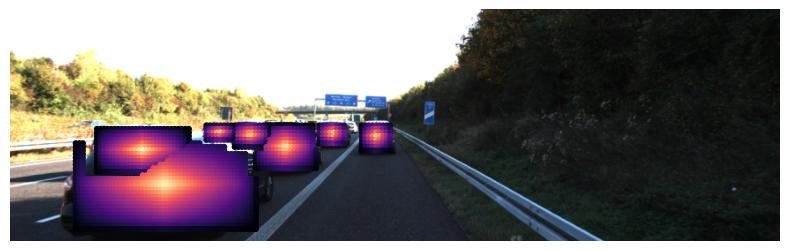

min centerness score:  0.0054848916
max centerness score:  0.98502415


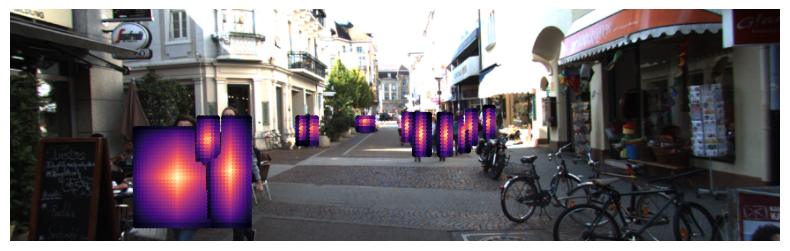

min centerness score:  0.007385527
max centerness score:  0.97627246


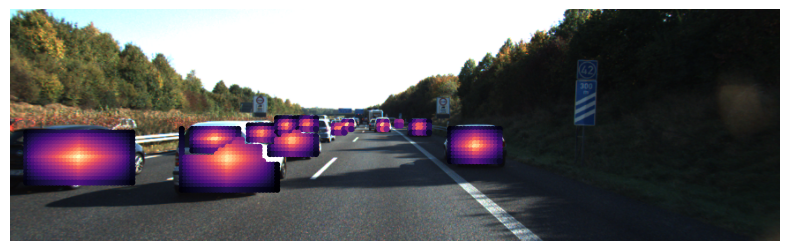

min centerness score:  0.0064212233
max centerness score:  0.982888


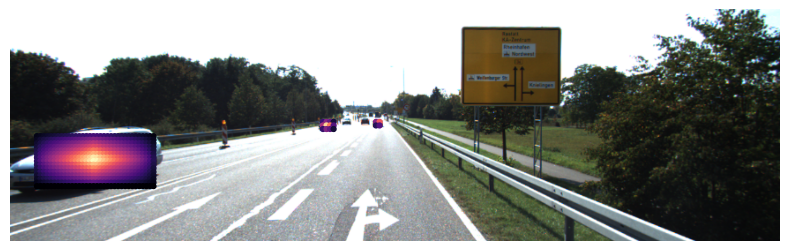

min centerness score:  0.0026041092
max centerness score:  0.93652797


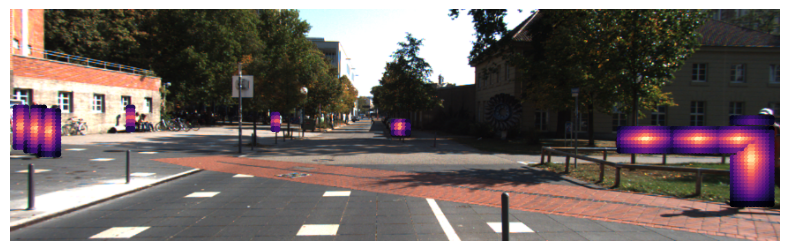

min centerness score:  0.006479281
max centerness score:  0.94458956


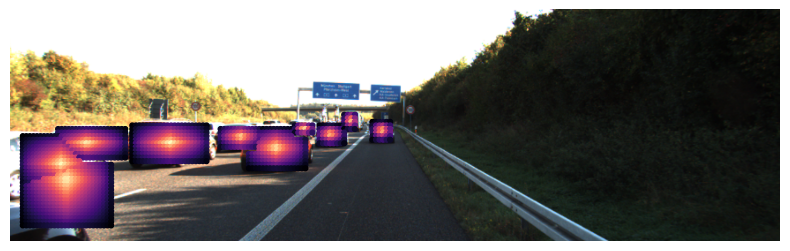

min centerness score:  0.017006721
max centerness score:  0.98178715


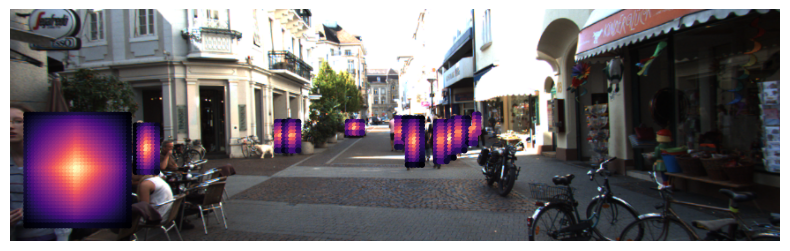

min centerness score:  0.01149879
max centerness score:  0.9570299


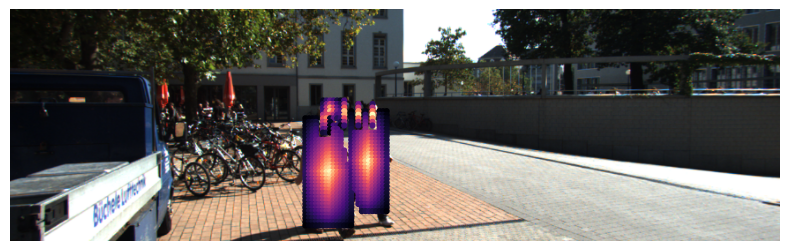

min centerness score:  0.015277244
max centerness score:  0.9572538


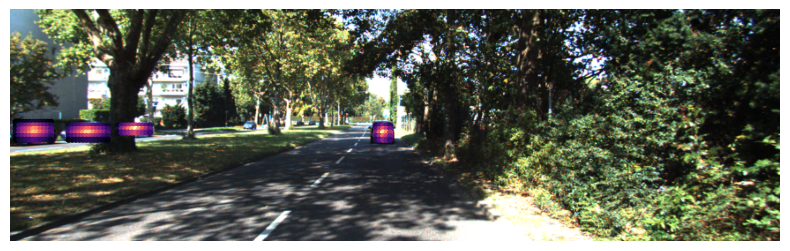

min centerness score:  0.012107383
max centerness score:  0.94127834


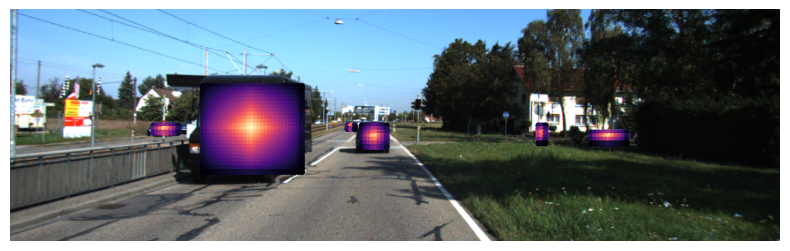

min centerness score:  0.016396973
max centerness score:  0.96734214


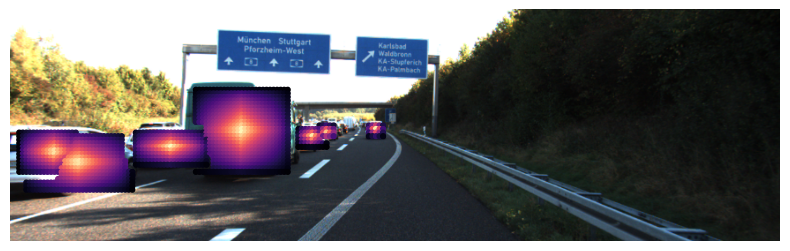

min centerness score:  0.0042329333
max centerness score:  0.97771513


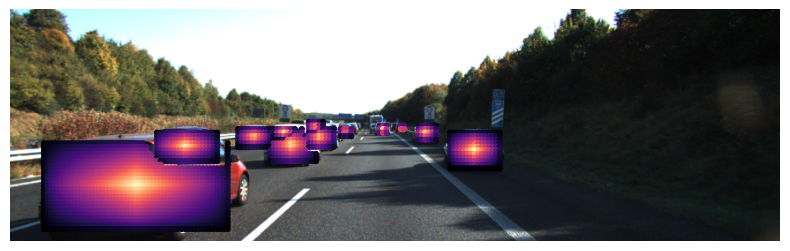

min centerness score:  0.0038598678
max centerness score:  0.980499


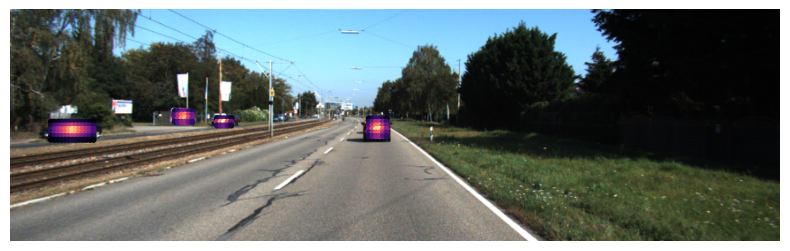

min centerness score:  0.022236273
max centerness score:  0.8860541


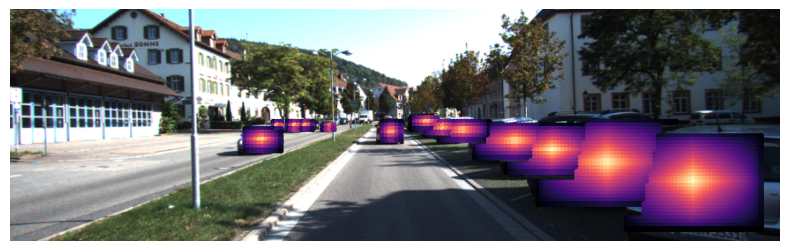

min centerness score:  0.0020638052
max centerness score:  0.9812291


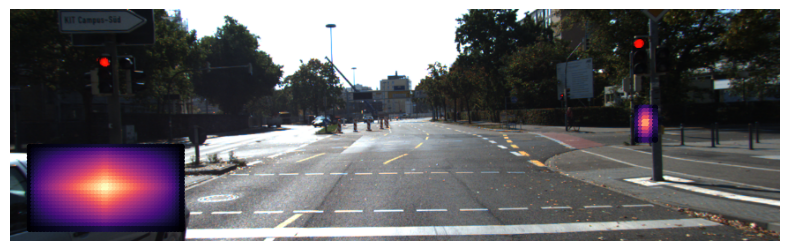

min centerness score:  0.0049180817
max centerness score:  0.94235164


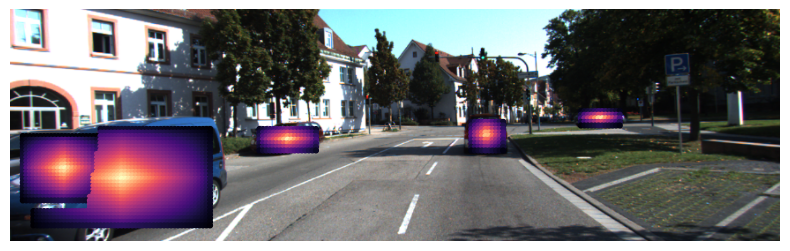

min centerness score:  0.0050406745
max centerness score:  0.97386867


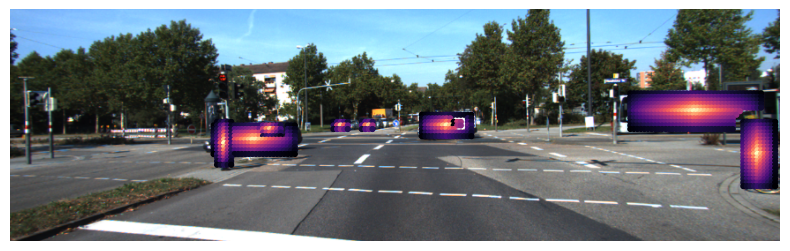

min centerness score:  0.014817708
max centerness score:  0.9762494


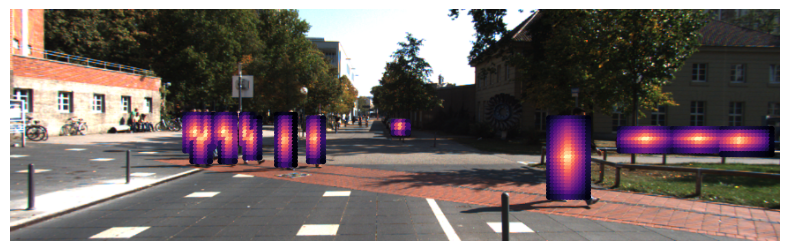

min centerness score:  0.0026451424
max centerness score:  0.9358425


In [4]:
image_idx = [14, 15, 16, 17, 18, 19, 20, 27, 29, 37, 53, 61, 63, 64, 89, 92, 93, 99]

for i in range(len(image_idx)):
    image, labels = kitti_dataset.__getitem__(image_idx[i])
    img_path = labels['img_path']
    bbox = labels['bbox']
    cls_label = labels['obj_class_label']
    bbox = bbox.to(device)
    cls_label = cls_label.to(device)

    matched_gt_class, \
    matched_gt_boxes = fcos_match_locations_to_gt_main(
        grid_coord, bbox, cls_label, device, 
        _IGNORED_CLASS_ID_, _SHRINK_FACTOR_, _MATCH_CRITERIA_)   # 'closest_box' or 'smallest_area'
    
    centerness = shrink_bbox_and_compute_centerness(grid_coord, matched_gt_boxes, strides_w, strides_h, _SHRINK_FACTOR_)
    # deltas = fcos_get_deltas_from_locations(grid_coord, matched_gt_boxes, strides_w, strides_h)
    # centerness = compute_centerness(deltas)

    positive_mask = matched_gt_class >= 0
    valid_centerness = centerness[positive_mask].cpu().numpy()
    valid_grid_coord = grid_coord[positive_mask].cpu().numpy()
    colors = generate_color(valid_centerness)
    visualize_centerness(
        img_path, 
        constants._IMG_RESIZED_W_, 
        constants._IMG_RESIZED_H_,
        valid_grid_coord,
        colors, 
        size = 12.0,
        alpha = 1.0,
        figsize=(8,6))
    
    print('min centerness score: ', np.min(valid_centerness))
    print('max centerness score: ', np.max(valid_centerness))
    print('=' * 100)

In [5]:
np.min(valid_centerness)

0.0026451424